In [37]:
import os
import pandas as pd
import numpy as np
import scanpy as sc
import anndata
from tqdm import tqdm
import optuna
import shap
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score,ConfusionMatrixDisplay,precision_score,recall_score
from sklearn.inspection import permutation_importance
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

In [2]:
pvat_8weeks = pd.read_csv('../data/8_Week_taPVAT_Control_HF_Diet/PVAT_8_Week_gene_x_cell_post_processed_dense_matrix.csv', index_col=0)
pvat_8weeks_metadata = pd.read_csv("../data/8_Week_taPVAT_Control_HF_Diet/PVAT_8_Week_Metadata.csv", index_col=0)

In [3]:
bat_8weeks = pd.read_csv('../data/8_Week_BAT_Control_HF_Diet/BAT_8_Week_gene_x_cell_post_processed_dense_matrix.csv', index_col=0)
bat_8weeks_metadata = pd.read_csv("../data/8_Week_BAT_Control_HF_Diet/BAT_8_Week_Metadata.csv", index_col=0)

In [4]:
# Transposing gene by cell to cell by gene matrix
pvat_8weeks = pvat_8weeks.T
bat_8weeks = bat_8weeks.T

In [5]:
pvat_8weeks.head()

GENE,Irgq,Doc2g,ENSRNOG00000064851,Zfp108,Got1,Trip13,Lrrc27,Map6,Zfyve27,Cyth2,...,LOC120099628,AABR07042936.1,ENSRNOG00000063068,ENSRNOG00000070158,ENSRNOG00000070819,AABR07015057.1,ENSRNOG00000063733,AABR07000398.1,ENSRNOG00000062942,ENSRNOG00000070895
AAACCCACAACAAAGT-1-2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,4.456666,0.0,3.408216,0.0,0.0
AAACGAACACGACGAA-1-2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,2.420004,0.0,2.420004,0.0,0.0
AAACGCTGTATGAGGC-1-2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,4.244609,0.0,3.174276,0.0,0.0
AAACGCTGTGCAACGA-1-2,0.0,0.0,0.0,0.0,1.012525,0.0,0.0,0.0,1.012525,0.0,...,0.0,0.0,0.0,0.0,0.0,3.632398,0.0,2.919143,0.0,0.0
AAAGAACAGGGCAGGA-1-2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,3.117873,0.0,3.508478,0.0,0.0


In [6]:
bat_8weeks.head()

GENE,Irgq,Doc2g,ENSRNOG00000064851,Zfp108,Got1,Trip13,Lrrc27,Map6,Zfyve27,Cyth2,...,LOC120099628,AABR07042936.1,ENSRNOG00000063068,ENSRNOG00000070158,ENSRNOG00000070819,AABR07015057.1,ENSRNOG00000063733,AABR07000398.1,ENSRNOG00000062942,ENSRNOG00000070895
AAACCCACATAATGCC-1-0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,1.54486,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,2.756794,0.0,3.812154,0.0,0.0
AAACGAACAATACAGA-1-0,0.0,0.0,0.0,0.0,2.586637,0.0,0.000000,0.00000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,2.586637,0.0,4.313615,0.0,0.0
AAACGAACAATACGAA-1-0,0.0,0.0,0.0,0.0,0.000000,0.0,1.724531,0.00000,0.0,0.766617,...,0.0,0.0,0.0,0.0,0.0,2.527704,0.0,2.615730,0.0,0.0
AAACGAATCGTTGTAG-1-0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,3.241421,0.0,2.794611,0.0,0.0
AAACGCTCACTAGAGG-1-0,0.0,0.0,0.0,0.0,0.859206,0.0,0.000000,0.00000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,2.584116,0.0,2.354133,0.0,0.0


In [7]:
pvat_8weeks.shape, bat_8weeks.shape

((14440, 15532), (5949, 15532))

In [8]:
pvat_control_cell_names = pvat_8weeks_metadata.loc[pvat_8weeks_metadata['diet']=='Control'].index.tolist()
bat_control_cell_names = bat_8weeks_metadata.loc[bat_8weeks_metadata['diet']=='Control'].index.tolist()
len(pvat_control_cell_names), len(bat_control_cell_names)

(5846, 5949)

In [9]:
pvat_control = pvat_8weeks.loc[pvat_control_cell_names]
bat_control = bat_8weeks.loc[bat_control_cell_names]

In [10]:
common_genes = list(set(pvat_8weeks.columns) & set(pvat_8weeks.columns))
len(common_genes)

15532

In [11]:
pvat_control = pvat_control[common_genes]
bat_control = bat_control[common_genes]

In [12]:
pvat_control['Cell_Type']='PVAT'
bat_control['Cell_Type']='BAT'

In [13]:
combined_data = pd.concat([pvat_control,bat_control],ignore_index=False)
combined_data = combined_data.sample(frac=1, random_state=42)
combined_data.head()

GENE,Carmil1,Map2k4,Ppp1r9b,Errfi1,Zfp263,Kcnq3,Rnpc3,Fdxr,Ctdp1,Clint1,...,Zpbp2,Stap1,Asmtl,Dnajc15,ENSRNOG00000067790,Hspa12b,Prmt2,Laptm4b,Zfand2b,Cell_Type
CATCCCATCATAGGCT-1-1,0.00000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,BAT
ATTGTTCCAGAGTCAG-1-4,2.25419,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,PVAT
GGGTGAAGTTAGCTAC-1-1,0.00000,0.0,0.000000,0.0,2.492087,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,BAT
TTTCACAGTGTCGCTG-1-1,0.00000,0.0,1.809904,0.0,0.000000,0.0,0.0,0.0,0.0,1.809904,...,0.0,0.0,0.0,1.809904,0.0,0.0,0.0,0.0,0.0,BAT
GCTCAAAAGGATGAGA-1-2,0.00000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,PVAT


In [15]:
adata = sc.AnnData(combined_data.iloc[:,:-1])
adata.obs['Cell_Type'] = combined_data.iloc[:,-1:]
adata

AnnData object with n_obs × n_vars = 11795 × 15532
    obs: 'Cell_Type'

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/pandavis/miniconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


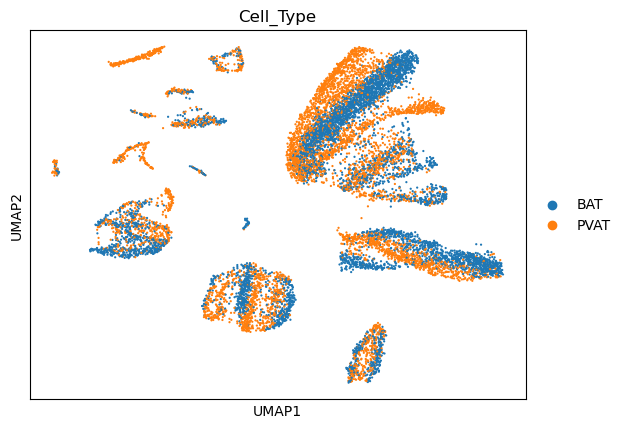

In [17]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata, random_state=42)
sc.pl.umap(adata, color='Cell_Type')

In [20]:
sc.pp.highly_variable_genes(adata, n_top_genes=500)
adata_hvg = adata[:, adata.var['highly_variable']]
adata_hvg

View of AnnData object with n_obs × n_vars = 11795 × 500
    obs: 'Cell_Type'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'Cell_Type_colors', 'hvg'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [21]:
adata_hvg_df = adata_hvg.to_df()
adata_hvg_df['Class'] = adata_hvg.obs['Cell_Type'].apply(lambda x: 1 if x == 'PVAT' else 0)
adata_hvg_df = adata_hvg_df.sample(frac=1)

In [22]:
train_temp, test = train_test_split(adata_hvg_df, test_size=0.2, stratify = adata_hvg_df['Class'])
train, val = train_test_split(train_temp, test_size=0.2, stratify=train_temp['Class'])
X_train = train[[i for i in train.columns.to_list() if i != 'Class']]
Y_train = train['Class']
X_val = val[[i for i in val.columns.to_list() if i != 'Class']]
Y_val = val['Class']
X_test = test[[i for i in test.columns.to_list() if i != 'Class']]
Y_test = test['Class']

In [23]:
def objective(trial):
    param_grid = {
        'verbosity': 0,
        'objective': 'binary:logistic',
        'nthread': -1,
        'seed': 42,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2), 
        'n_estimators': trial.suggest_categorical('n_estimators', [50, 100, 200, 500]),
        'max_depth': trial.suggest_categorical('max_depth', [2, 4, 6]),
        'min_child_weight': trial.suggest_categorical('min_child_weight', [2, 4]),
        'gamma': trial.suggest_categorical('gamma', [0.4, 0.5, 0.6, 0.7]),
        'subsample': trial.suggest_categorical('subsample', [0.5, 0.6, 0.7, 0.8]),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.5, 0.6, 0.7, 0.8]),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0)
    }

    model = xgb.XGBClassifier(**param_grid)
    model.fit(X_train, Y_train, eval_set=[(X_val, Y_val)], verbose=False, early_stopping_rounds=50)
    preds = model.predict(X_val)
    score = f1_score(Y_val, preds)
    
    return score

In [24]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=700)

[I 2024-05-16 06:37:47,042] A new study created in memory with name: no-name-a4c3ab46-f1dd-4109-90c1-ed6c8c7e5213
/var/folders/kk/5gbzbkc93xb_g56p3bt9t8gh0000gp/T/ipykernel_76235/1602239752.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
/var/folders/kk/5gbzbkc93xb_g56p3bt9t8gh0000gp/T/ipykernel_76235/1602239752.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0)
/Users/pandavis/miniconda3/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-l

In [25]:
print("Best parameters:", study.best_params)
print("Best F1 score:", study.best_value)

Best parameters: {'learning_rate': 0.07503290623211203, 'n_estimators': 500, 'max_depth': 6, 'min_child_weight': 4, 'gamma': 0.4, 'subsample': 0.7, 'colsample_bytree': 0.6, 'reg_alpha': 0.004972438883638908, 'lambda': 1.498714647915518}
Best F1 score: 0.853606027987083


In [33]:
datasets = {
        "Train": (X_train, Y_train),
        "Validation": (X_val, Y_val),
        "Test": (X_test, Y_test)
    }

best_params = study.best_params
model = xgb.XGBClassifier(**best_params)
X_train, Y_train = datasets["Train"]
model.fit(X_train, Y_train)

fpr, tpr, auc_val = None, None, None

for dataset_name, (X, Y) in datasets.items():
    y_predicted = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]

    f1 = f1_score(y_pred=y_predicted, y_true=Y)
    precision = precision_score(Y, y_predicted)
    recall = recall_score(Y, y_predicted)
    accuracy = accuracy_score(Y, y_predicted)

    if dataset_name == "Test":
        fpr, tpr, _ = roc_curve(Y, y_prob)
        auc_val = auc(fpr, tpr)
        cm = confusion_matrix(Y, y_predicted)

    print(f"------ {dataset_name} Scores ------")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print("-----------------------------\n")

------ Train Scores ------
F1 Score: 0.9709
Precision: 0.9801
Recall: 0.9618
Accuracy: 0.9714
-----------------------------

------ Validation Scores ------
F1 Score: 0.8476
Precision: 0.8545
Recall: 0.8408
Accuracy: 0.8501
-----------------------------

------ Test Scores ------
F1 Score: 0.8416
Precision: 0.8565
Recall: 0.8272
Accuracy: 0.8457
-----------------------------



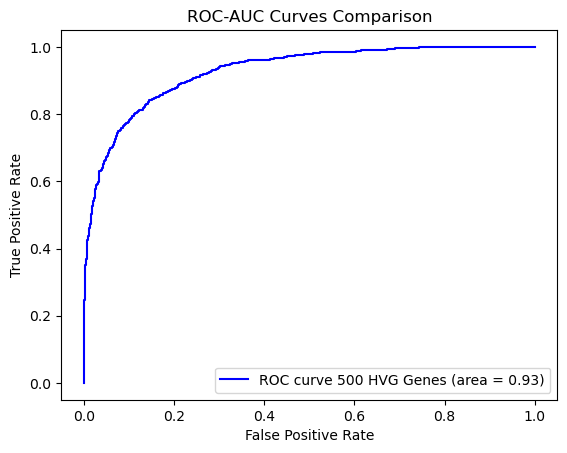

In [36]:
plt.plot(fpr, tpr, label='ROC curve 500 HVG Genes (area = %.2f)' %auc_val,color='blue')
plt.title('ROC-AUC Curves Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

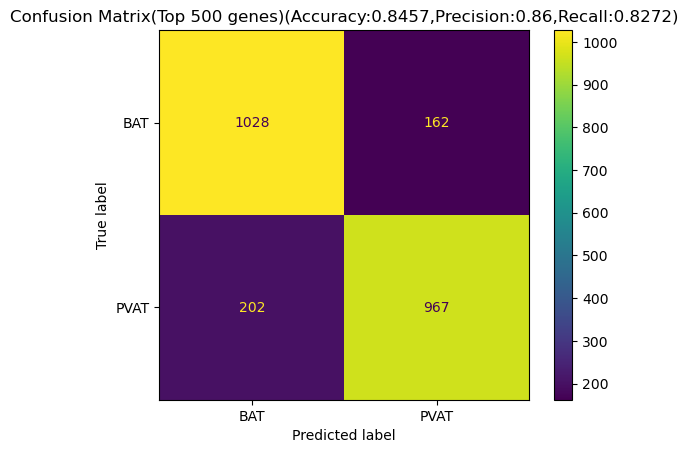

In [35]:
ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=np.array(['BAT','PVAT'])).plot()
plt.title(f'Confusion Matrix(Top 500 genes)(Accuracy:{accuracy:.4f},Precision:{precision:.2f},Recall:{recall:.4f})')
plt.show()

In [50]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

vals = np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(X_test.columns,vals)),columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)

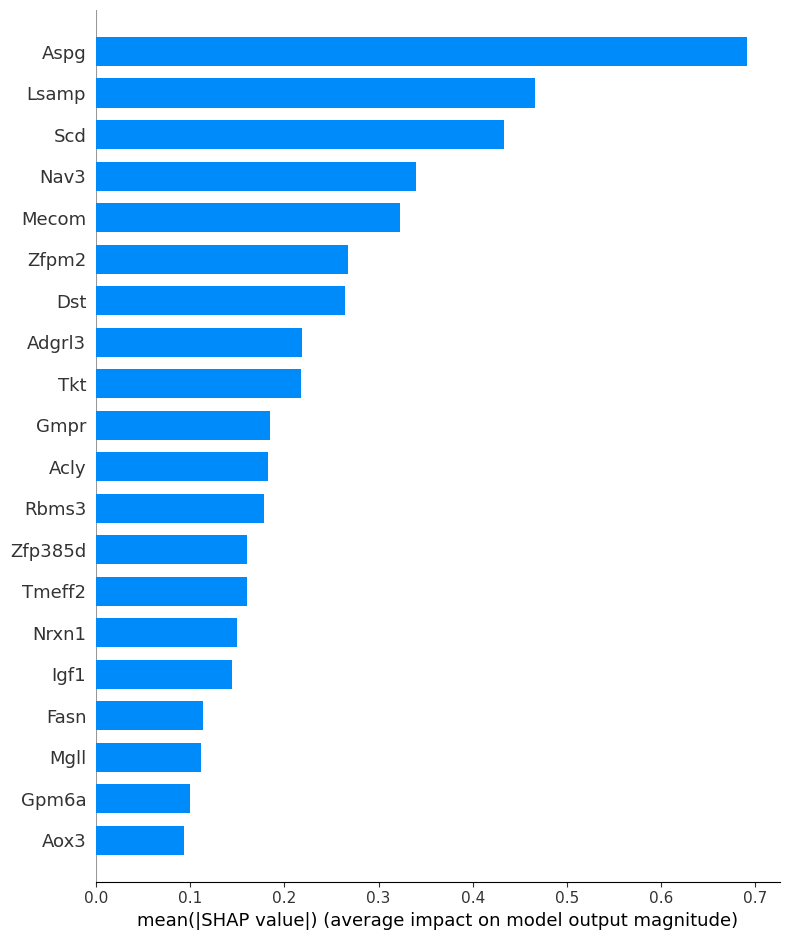

In [54]:
plt.figure(figsize=(10, 5))
shap.summary_plot(shap_values, X_test, plot_type="bar")
plt.title("Feature Importance Based on SHAP Values")
plt.close()

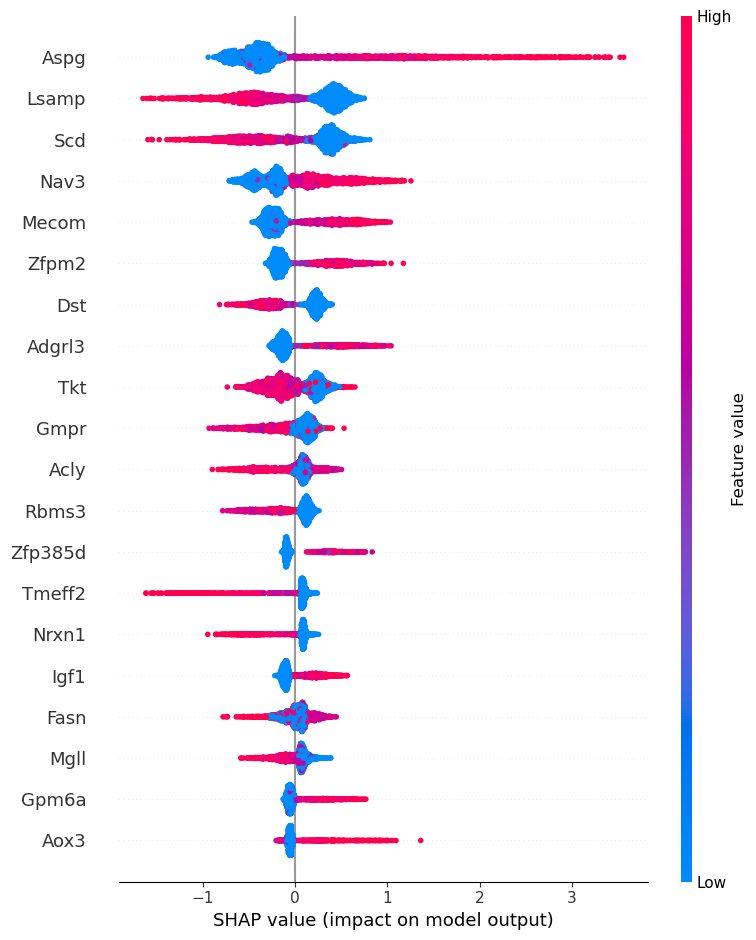

In [55]:
plt.figure(figsize=(15, 10))
shap.summary_plot(shap_values, X_test)
plt.close()